In [10]:
from astropy.modeling.models import BlackBody1D
from astropy.modeling.blackbody import FLAM
from astropy import units as u
from astropy.visualization import quantity_support
from astropy.convolution import convolve_fft

import matplotlib as mpl
import matplotlib.pyplot as plt
from glob import glob
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import interact_manual
from ipywidgets import FloatSlider
from ipywidgets import Button, Layout, Box, HBox, VBox
from colorama import Fore
from IPython.display import display
from IPython.display import clear_output

import numpy as np
import pandas as pd
import math

mpl.rcParams['figure.figsize'] = 12, 9

In [11]:
sirius = pd.read_csv('Sirius.csv')
b_fil = pd.read_csv('B Filter.csv')
u_fil = pd.read_csv('U Filter.csv')
v_fil = pd.read_csv('V Filter.csv')

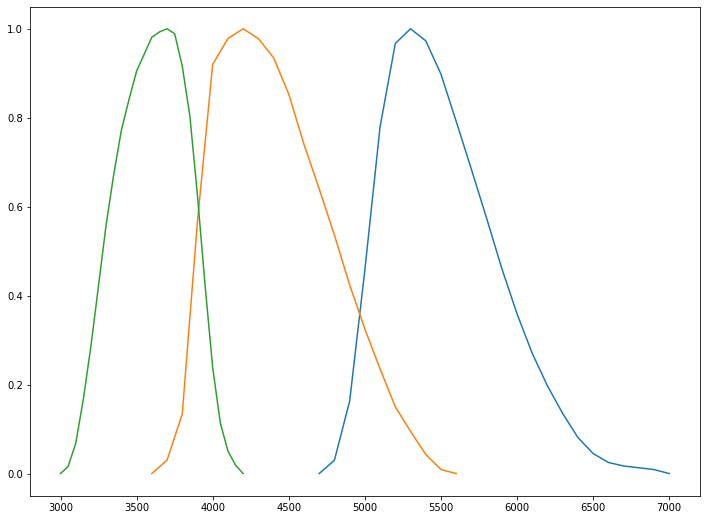

In [12]:
plt.plot(v_fil.iloc[:,0], v_fil.iloc[:,1])
plt.plot(b_fil.iloc[:,0], b_fil.iloc[:,1])
plt.plot(u_fil.iloc[:,0], u_fil.iloc[:,1])

In [13]:
#Getting the UBV filter transmittance and wavelength data into arrays, and bandwidth data
i = 0
u_trans = np.array([])
for i in u_fil['Transmittance']:
    u_trans = np.append(u_trans, i)
i = 0
u_wav = np.array([])
for i in u_fil['lambda']:
    u_wav = np.append(u_wav, i)
b_trans = np.array([])
i = 0
for i in b_fil['Transmittance']:
    b_trans = np.append(b_trans,i)
i = 0
b_wav = np.array([])
for i in b_fil['lambda']:
    b_wav = np.append(b_wav, i)
v_trans = np.array([])
i = 0
for i in v_fil['Transmittance']:
    v_trans = np.append(v_trans, i)
i = 0
v_wav = np.array([])
for i in v_fil['lambda']:
    v_wav = np.append(v_wav, i)

u_band = u_wav[-1] - u_wav[0]
b_band = b_wav[-1] - b_wav[0]
v_band = v_wav[-1] - v_wav[0]
print('u', u_trans.size, u_wav.size)
print('b', b_trans.size, b_wav.size)
print('v', v_trans.size, v_wav.size)
print(u_band, b_band, v_band)

u 25 25
b 21 21
v 24 24
1200.0 2000.0 2300.0


In [14]:
#Getting approx. where Sirius' wavelength match the filters and append corresponding flux
#This only picks the first value within a threshold, not necessarily the closest value but its close enough for now
i = 0
j = 0
k = 0
l = 0
u_flux = np.array([])
b_flux = np.array([])
v_flux = np.array([])
while i < sirius.size:
    if sirius['lambda'][i] + 2 > u_wav[j] and sirius['lambda'][i] - 2 < u_wav[j]:
        u_flux = np.append(u_flux, sirius['Flux'][i])
        if j < u_wav.size - 1:
            j+=1
        else:
            j = 0
    if sirius['lambda'][i] + 3 > b_wav[k] and sirius['lambda'][i] - 3 < b_wav[k]:
        b_flux = np.append(b_flux, sirius['Flux'][i])
        if k < b_wav.size - 1:
            k+=1
        else:
            k = 0
    if sirius['lambda'][i] + 3 > v_wav[l] and sirius['lambda'][i] - 3 < v_wav[l]:
        v_flux = np.append(v_flux, sirius['Flux'][i])
        if l < v_wav.size - 1:
            l+=1
        else:
            l = 0
    if sirius['lambda'][i] > v_wav[-1]:
        break
    i+=1
print('u', u_flux.size)
print('b', b_flux.size)
print('v', v_flux.size)
print(u_flux)

u 25
b 21
v 24
[1.55e-08 1.67e-08 1.51e-08 1.63e-08 1.52e-08 1.54e-08 1.53e-08 1.50e-08
 1.48e-08 1.47e-08 1.41e-08 1.44e-08 1.40e-08 1.37e-08 1.37e-08 1.43e-08
 1.47e-08 2.92e-08 2.43e-08 3.22e-08 3.27e-08 3.37e-08 1.28e-08 3.16e-08
 3.02e-08]


In [15]:
#Getting the light through the filter
def filt(u_trans, b_trans, v_trans, u_flux, b_flux, v_flux):
    i = 0
    fil_u = np.array([])
    fil_b = np.array([])
    fil_v = np.array([])
    while i < u_flux.size:
        temp_u = u_trans[i]*u_flux[i]
        fil_u = np.append(fil_u, temp_u)
        if i < b_flux.size - 1:
            temp_b = b_trans[i]*b_flux[i]
            fil_b = np.append(fil_b, temp_b)
        if i < v_flux.size - 1:
            temp_v = v_trans[i]*v_flux[i]
            fil_v = np.append(fil_v, temp_v)
        i+=1
    return fil_u, fil_b, fil_v
fil_u, fil_b, fil_v = filt(u_trans, b_trans, v_trans, u_flux, b_flux, v_flux)
print(fil_u)
print(fil_b)
print(fil_v)

[0.00000e+00 2.67200e-10 1.02680e-09 2.72210e-09 4.36240e-09 6.51420e-09
 8.56800e-09 1.00950e-08 1.14256e-08 1.23627e-08 1.27605e-08 1.35792e-08
 1.37340e-08 1.36041e-08 1.37000e-08 1.41427e-08 1.34652e-08 2.34768e-08
 1.51875e-08 1.36206e-08 7.78260e-09 3.84180e-09 6.52800e-10 6.00400e-10
 0.00000e+00]
[0.00000e+00 4.11000e-10 1.90280e-09 1.12833e-08 3.00840e-08 1.25184e-08
 3.02000e-08 2.69928e-08 2.49645e-08 2.16662e-08 1.78340e-08 1.45920e-08
 1.12560e-08 8.09840e-09 6.01250e-09 4.11250e-09 2.46000e-09 1.50100e-09
 6.32100e-10 1.26000e-10]
[0.00000e+00 6.30000e-10 3.11330e-09 8.47300e-09 1.36500e-08 1.58588e-08
 1.58000e-08 1.43031e-08 1.25720e-08 1.05336e-08 8.68680e-09 6.88800e-09
 5.20930e-09 3.87720e-09 2.75400e-09 1.92075e-09 1.24740e-09 7.12800e-10
 3.70800e-10 1.91000e-10 1.29540e-10 9.45100e-11 6.25500e-11]


In [16]:
#Get U, B, V and Sirius correction
def ubv(fil_u, fil_b, fil_v):
    U = np.sum(fil_u) * u_band
    B = np.sum(fil_b) * b_band
    V = np.sum(fil_v) * v_band
    return U, B, V
U, B, V = ubv(fil_u, fil_b, fil_v)
def f(x,y):
    return -2.5*math.log10(x/y)
U_B = f(U, B)
B_V = f(B, V)
U_Bcorr = - U_B
B_Vcorr = - B_V
print(U_Bcorr, B_Vcorr)

-0.5993899907675627 0.4764529590866824


In [17]:
#Plot and such for blackbody curve
h = 6.626e-34
c = 3e8
k = 1.38e-23
hc = h*c
def bb(wav, T):
    a = hc/(wav*k*T)
    p1 = 2*hc**2 / wav**5
    p2 = 1 / (np.exp(a) - 1)
    return p1*p2
def slider(T):
    wavelengths = np.arange(2e-9, 3e-6, 1e-9)
    i = bb(wavelengths, T)
    plt.plot(wavelengths*1e10, i, 'r-') 
    plt.ylabel('Intensity')
    plt.xlabel('Wavelength (Angstroms)')
    wavelengths *= 1e10
    wavelengths = np.round(wavelengths, 2)
    j = 0
    m = 0
    l = 0
    temp_u = np.array([])
    temp_b = np.array([])
    temp_v = np.array([])
    for temp in wavelengths:
        if temp == u_wav[j]:
            w = temp * 1e-10
            temp_u = np.append(temp_u, bb(w, T))
            if j < u_wav.size -1:
                j+=1
            else:
                j = 0
        if temp == b_wav[m]:
            w = temp * 1e-10
            temp_b = np.append(temp_b, bb(w, T))
            if m < b_wav.size -1:
                m+=1
            else:
                m = 0
        if temp == v_wav[l]:
            w = temp * 1e-10
            temp_v = np.append(temp_v, bb(w, T))
            if l < v_wav.size -1:
                l+=1
            else:
                l = 0
    tempfil_u, tempfil_b, tempfil_v = filt(u_trans, b_trans, v_trans, temp_u, temp_b, temp_v)
    temp_U, temp_B, temp_V = ubv(tempfil_u*1e10, tempfil_b*1e10, tempfil_v*1e10)
    tempU_B = f(temp_U, temp_B)
    tempB_V = f(temp_B, temp_V)
    lam_peak = 2.9e7/T
    print('Peak wavelength Angstroms:', lam_peak)
    print('U-B:', tempU_B + U_Bcorr)
    print('B-V:', tempB_V + B_Vcorr)
    if T > 0:
        return T
    else:
        return 6000
interact_manual(slider, T = 6000)

interactive(children=(IntSlider(value=6000, description='T', max=18000, min=-6000), Button(description='Run In…

<function __main__.slider(T)>

I know I did something wrong, but am not quite sure where. The B-V seems about right because it is about zero close to 10000K, but the U-B is close to zero at 5000K....